✅ Data loaded
Sales rows: 878371
Wholesale aggregated
Final rows: 878371

📊 SUMMARY
Total Records: 878371
Unique Items: 246
Avg Quantity: 0.5364314270393719
Avg Selling Price: 8.917346428786928
Avg Wholesale Price: 5.892112149418385
Avg Loss Rate (%): 10.122672959375933


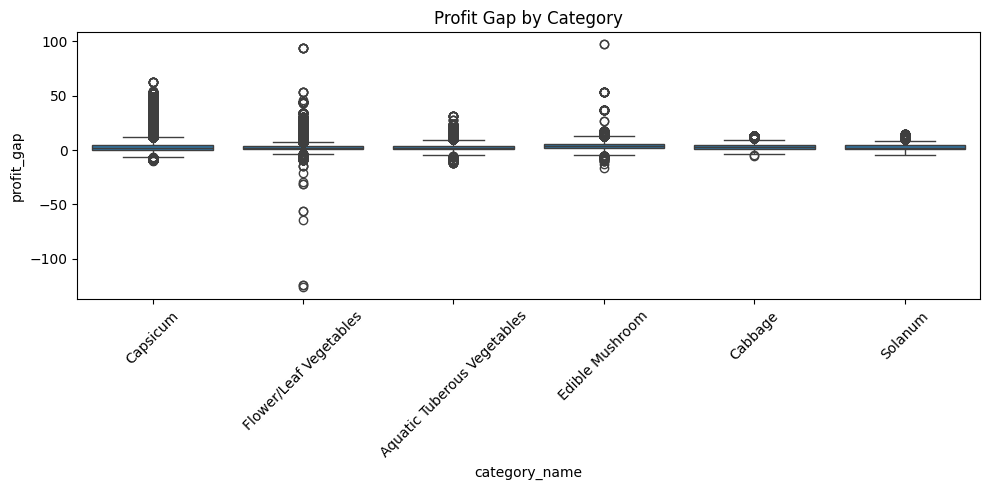


✅ master_dataset.csv saved


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# 1. LOAD DATA
# =========================
annex1 = pd.read_csv("annex1.csv")
annex2 = pd.read_csv("annex2.csv")
annex3 = pd.read_csv("annex3.csv")
annex4 = pd.read_csv("annex4.csv")

print("✅ Data loaded")

# =========================
# 2. CLEAN ANNEX 1 (ITEM MASTER)
# =========================
annex1.columns = annex1.columns.str.strip().str.lower()
annex1 = annex1.rename(columns={
    "item code": "item_code",
    "item name": "item_name",
    "category c": "category_code",
    "category name": "category_name"
})
annex1["item_code"] = annex1["item_code"].astype(str)

# =========================
# 3. CLEAN ANNEX 2 (SALES – FACT TABLE)
# =========================
annex2.columns = (
    annex2.columns
    .str.strip()
    .str.lower()
    .str.replace(r"\s+", " ", regex=True)
)

annex2 = annex2.rename(columns={
    "item code": "item_code",
    "quantity sold (kilo)": "quantity",
    "unit selling price (rmb/kg)": "unit_selling",
    "sale or return": "sale_or_return",
    "discount (yes/no)": "discount_flag"
})

annex2["item_code"] = annex2["item_code"].astype(str)
annex2["quantity"] = pd.to_numeric(annex2["quantity"], errors="coerce").clip(lower=0)
annex2["unit_selling"] = pd.to_numeric(annex2["unit_selling"], errors="coerce").clip(lower=0)
annex2["discount_flag"] = annex2["discount_flag"].map({"Yes": True, "No": False})

annex2["timestamp"] = pd.to_datetime(
    annex2["date"].astype(str) + " " + annex2["time"].astype(str),
    errors="coerce"
)

annex2 = annex2.dropna(subset=["timestamp", "item_code"])

print(f"Sales rows: {len(annex2)}")

# =========================
# 4. CLEAN & AGGREGATE ANNEX 3 (WHOLESALE → ONE ROW PER ITEM)
# =========================
annex3.columns = annex3.columns.str.strip().str.lower()
annex3 = annex3.rename(columns={
    "item code": "item_code",
    "wholesale price (rmb/kg)": "wholesale_price"
})

annex3["item_code"] = annex3["item_code"].astype(str)
annex3["wholesale_price"] = pd.to_numeric(annex3["wholesale_price"], errors="coerce")

# 🔑 AGGREGATION (CRITICAL FIX)
annex3 = annex3.groupby("item_code", as_index=False)["wholesale_price"].mean()

print("Wholesale aggregated")

# =========================
# 5. CLEAN ANNEX 4 (LOSS RATE – ALREADY ONE ROW PER ITEM)
# =========================
annex4.columns = annex4.columns.str.strip().str.lower()
annex4 = annex4.rename(columns={
    "item code": "item_code",
    "loss rate (%)": "loss_rate"
})

annex4["item_code"] = annex4["item_code"].astype(str)
annex4["loss_rate"] = pd.to_numeric(annex4["loss_rate"], errors="coerce")

# =========================
# 6. SAFE MERGE (NO MEMORY EXPLOSION)
# =========================
master_df = annex2.merge(annex1, on="item_code", how="left")
master_df = master_df.merge(annex3, on="item_code", how="left")
master_df = master_df.merge(annex4, on="item_code", how="left")

print(f"Final rows: {len(master_df)}")

# =========================
# 7. BASIC EDA
# =========================
summary = {
    "Total Records": len(master_df),
    "Unique Items": master_df["item_code"].nunique(),
    "Avg Quantity": master_df["quantity"].mean(),
    "Avg Selling Price": master_df["unit_selling"].mean(),
    "Avg Wholesale Price": master_df["wholesale_price"].mean(),
    "Avg Loss Rate (%)": master_df["loss_rate"].mean()
}

print("\n📊 SUMMARY")
for k, v in summary.items():
    print(f"{k}: {v}")

# =========================
# 8. FEATURE ENGINEERING
# =========================
master_df["profit_gap"] = master_df["unit_selling"] - master_df["wholesale_price"]

# =========================
# 9. VISUALIZATION
# =========================
plt.figure(figsize=(10, 5))
sns.boxplot(x="category_name", y="profit_gap", data=master_df)
plt.xticks(rotation=45)
plt.title("Profit Gap by Category")
plt.tight_layout()
plt.show()

# =========================
# 10. SAVE OUTPUT
# =========================
master_df.to_csv("master_dataset.csv", index=False)
print("\n✅ master_dataset.csv saved")


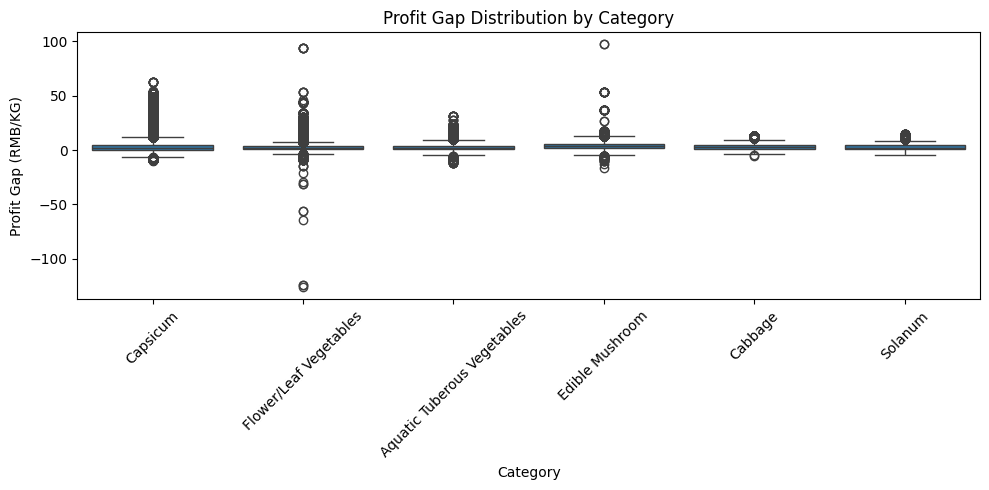

In [3]:
plt.figure(figsize=(10,5))
sns.boxplot(
    x="category_name",
    y="profit_gap",
    data=master_df
)
plt.xticks(rotation=45)
plt.title("Profit Gap Distribution by Category")
plt.xlabel("Category")
plt.ylabel("Profit Gap (RMB/KG)")
plt.tight_layout()
plt.show()


C:\Users\yasha\AppData\Local\Temp\ipykernel_10332\3748936768.py:18: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\yasha\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


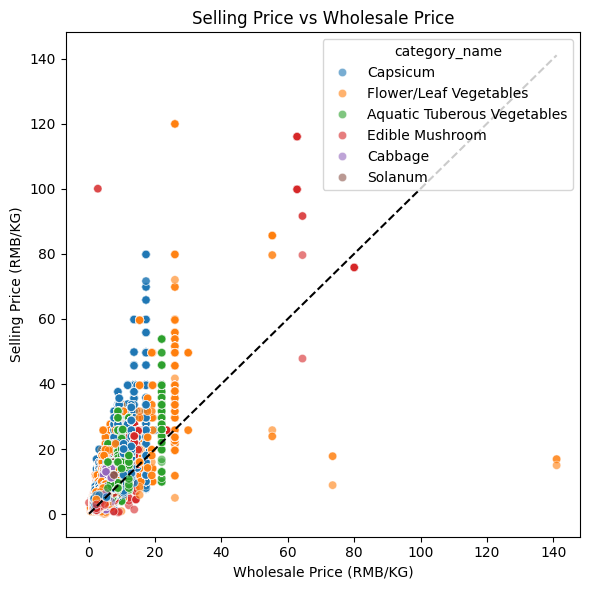

In [4]:
plt.figure(figsize=(6,6))
sns.scatterplot(
    x="wholesale_price",
    y="unit_selling",
    hue="category_name",
    data=master_df,
    alpha=0.6
)
plt.plot(
    [master_df["wholesale_price"].min(), master_df["wholesale_price"].max()],
    [master_df["wholesale_price"].min(), master_df["wholesale_price"].max()],
    linestyle="--",
    color="black"
)
plt.xlabel("Wholesale Price (RMB/KG)")
plt.ylabel("Selling Price (RMB/KG)")
plt.title("Selling Price vs Wholesale Price")
plt.tight_layout()
plt.show()


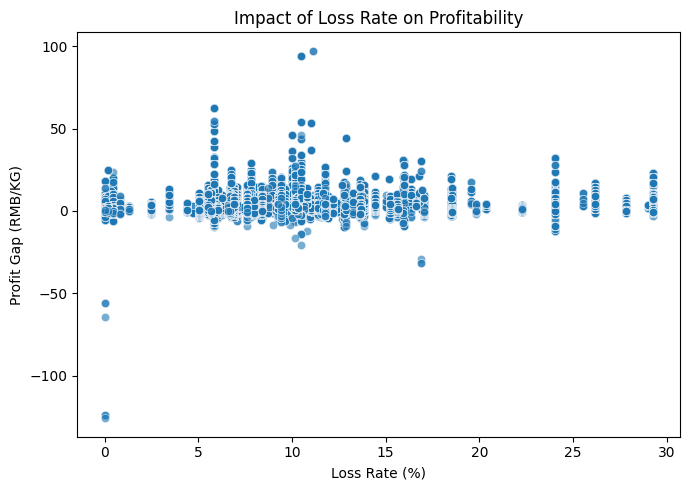

In [5]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    x="loss_rate",
    y="profit_gap",
    data=master_df,
    alpha=0.6
)
plt.xlabel("Loss Rate (%)")
plt.ylabel("Profit Gap (RMB/KG)")
plt.title("Impact of Loss Rate on Profitability")
plt.tight_layout()
plt.show()


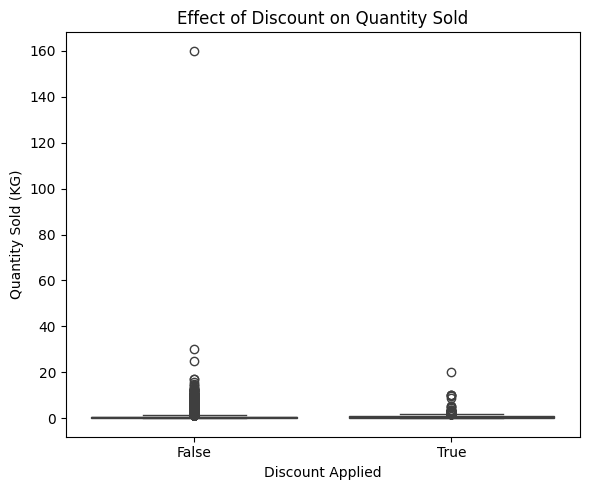

In [6]:
plt.figure(figsize=(6,5))
sns.boxplot(
    x="discount_flag",
    y="quantity",
    data=master_df
)
plt.xlabel("Discount Applied")
plt.ylabel("Quantity Sold (KG)")
plt.title("Effect of Discount on Quantity Sold")
plt.tight_layout()
plt.show()


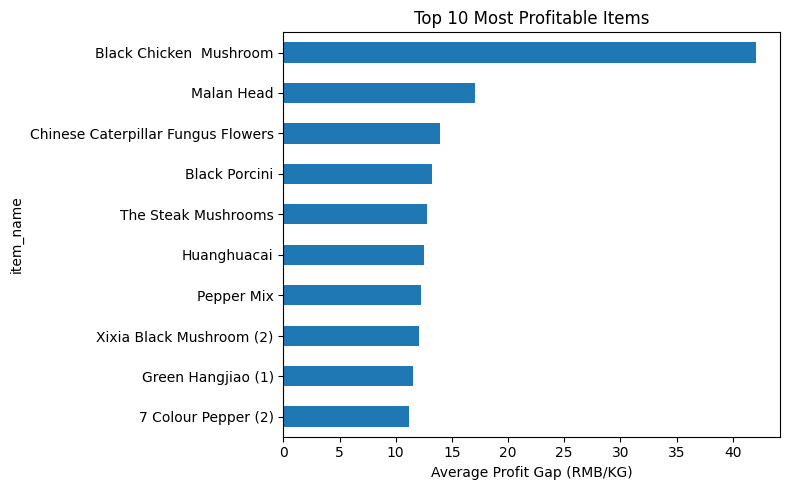

In [7]:
top_items = (
    master_df
    .groupby("item_name")["profit_gap"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(8,5))
top_items.plot(kind="barh")
plt.xlabel("Average Profit Gap (RMB/KG)")
plt.title("Top 10 Most Profitable Items")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
